# Build basic algorithms from scratch

I've been considering to build from scratch the basic machine learning algorithms for a long time. Due to various reasons - I was too busy or focused on other topics, I had to postpone this exercise. The summer of 2022, however, proved to be the right time for it. Thus, this Notebook presents a simple implementation of Linear Regression, Logistic Regression, and K-means clustering. I use small and not so complex public datasets; the focus is not on data exploration or cleaning, or on model performance but on how each algorithm works. For this reason, only the math behind them is explained. The other steps are accompanied with minor comments.

### Imports

In [ ]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

## I. Linear Regression

Linear Regression is a statistical technique for measuring the relationship between independent and dependent variables. It shows how the dependent variable ($y$) changes with altering the independent variable(s) ($X$). Its predictions are continuous values.

A simple dataset is used for building and testing a Linear Regression from scratch. The dataset has one feature (independent variable) - `population` and one target (dependent variable) - `profit`. It shows how change in population impacts profits size. The data are taken from [here](https://raw.githubusercontent.com/FlorianMuellerklein/Machine-Learning/master/Data/ex1data1.txt).

#### 1. Load Data

In [3]:
pop_data = pd.read_csv(
    "https://raw.githubusercontent.com/FlorianMuellerklein/Machine-Learning/master/Data/ex1data1.txt", 
    header=None)
pop_data

,0,1
0,6.1101,17.59200
1,5.5277,9.13020
2,8.5186,13.66200
3,7.0032,11.85400
4,5.8598,6.82330
...,...,...
92,5.8707,7.20290
93,5.3054,1.98690
94,8.2934,0.14454
95,13.3940,9.05510


Column titles were renamed since the dataset was published without names.

In [4]:
pop_data.columns = ["population", "profit"]
pop_data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


#### 2. Exploratory Data Analysis. Visualizations

The dataset has 97 samples (rows) and 2 columns.

In [5]:
pop_data.shape

(97, 2)

Values in both columns are numeric. There are not missing entries.

In [6]:
pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  97 non-null     float64
 1   profit      97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


Both `population` and `profit` are in 10 000s, i.e 10K is multiplier for each data point. The code line below displays the basic statistics for each column.

In [7]:
pop_data.describe().T

,count,mean,std,min,25%,50%,75%,max
population,97.0,8.159800,3.869884,5.0269,5.7077,6.5894,8.5781,22.203
profit,97.0,5.839135,5.510262,-2.6807,1.9869,4.5623,7.0467,24.147


There seems to be a strong correlation (0.837) between the two variables.

In [8]:
pop_data.corr()

,population,profit
population,1.000000,0.837873
profit,0.837873,1.000000


The plot below displays the data points and their regression line.

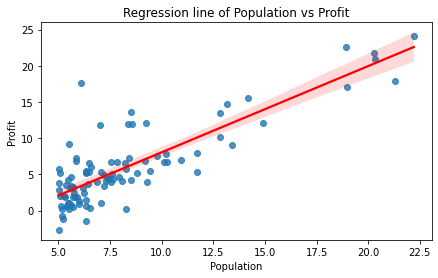

In [9]:
plt.figure(figsize = (7, 4))
sns.regplot(x = pop_data["population"], y = pop_data["profit"], line_kws = {"color": "red"}) 

plt.xlabel("Population")
plt.ylabel("Profit")
plt.title("Regression line of Population vs Profit")
plt.show()

Data density of both variables are shown below.

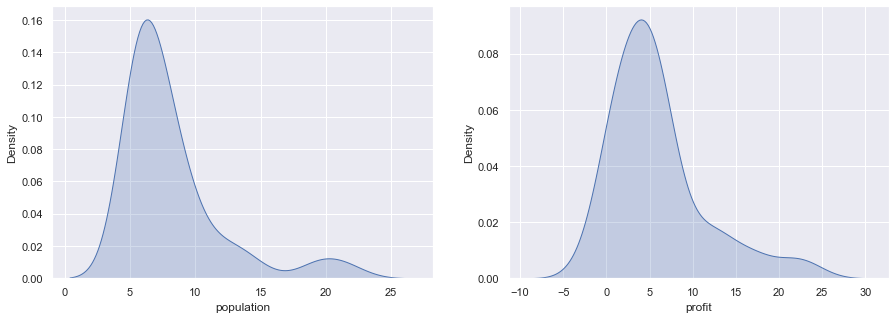

In [10]:
sns.set(rc = {"figure.figsize": (15,5)})
fig, ax = plt.subplots(1, 2)
sns.kdeplot(x = pop_data["population"], shade = True, ax = ax[0])
sns.kdeplot(x = pop_data["profit"], shade = True, ax = ax[1])
plt.show()

#### 3. Prepare data for modelling

Values in both columns are stored in separate variables - $X$ holds information about `population`, and $Y$ - about `profit`.

In [11]:
X = pop_data["population"]
Y = pop_data["profit"]

Feature and target were split into train and test set. 80% were alocated for training; the remaining was used for testing. Their shapes are checked thereafter.

In [12]:
X_train = X.sample(frac = 0.8, random_state = 42)
X_test = X.drop(X_train.index)

Y_train = Y.sample(frac = 0.8, random_state = 42)
Y_test = Y.drop(Y_train.index)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((78,), (78,), (19,), (19,))

Data should be in *NumPy* format. The code line below checks their type.

In [13]:
type(X_train)

pandas.core.series.Series

The function below converts *Pandas* Series into *NumPy* arrays.

In [14]:
def convert_to_numpy(data):
    """
    Convert a dataset to a NumPy array
    Args: Pandas DataFrame or a Pandas Series
    Returns: A NumPy array
    """
    return data.to_numpy()

In [15]:
X_train = convert_to_numpy(X_train)
Y_train = convert_to_numpy(Y_train)
X_test = convert_to_numpy(X_test)
Y_test = convert_to_numpy(Y_test)

The scatter plots below show the data and their regression line. Both sets have similar distribution.

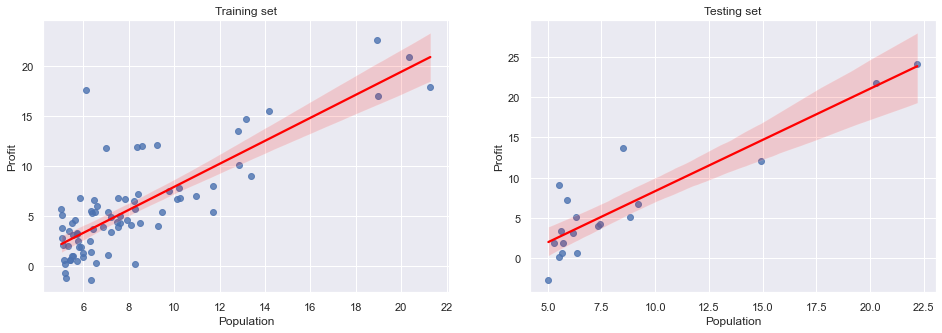

In [16]:
plt.figure(figsize = (16, 5))

plt.subplot(1, 2, 1)
sns.regplot(x = X_train, y = Y_train, line_kws = {"color": "red"}) 
plt.xlabel("Population")
plt.ylabel("Profit")
plt.title("Training set")

plt.subplot(1, 2, 2)
sns.regplot(x = X_test, y = Y_test, line_kws = {"color": "red"}) 
plt.xlabel("Population")
plt.ylabel("Profit")
plt.title("Testing set")
plt.show()

#### 4. Perform Linear Regression

All Linear Regression computations are wrapped in the function below. It returns $MSE$, $RMSE$, and $R^2$.

The formula for computing $MSE$ (Mean Squared Error) is: $MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \tilde{Y}_i)^2$.

The formula for computing $RMSE$ (Root Mean Squared Error) is: $RMSE = \sqrt \frac{1}{n} \sum_{i=1}^{n} (Y_i - \tilde{Y}_i)^2$.

The formula for computing $R^2$ (Coefficient of determination) is: $R^2 = \frac {\sum_{i=1}^{n} (Y_i - \tilde{Y}_i)^2}{\sum_{i=1}^{n} (Y_i - \overline{Y})^2} $.

where $Y$ are observed values, $\tilde{Y}$ are predicted values, and $\overline{Y}$ are mean values.

The formula for computing $\tilde{Y}$ is: $\tilde{Y} = aX + b$, where $a$ is the slope, and $b$ - the intercept of the line.

Low $MSE$ and $RMSE$, and high $R^2$ suggest the model is capable to well explain the relationship between the data.

In [17]:
def make_linear_regression(X_train: float, 
                           Y_train: float, 
                           X_test: float, 
                           Y_test: float):
    """
    Performs Linear Regression and computes basic metrics.
    Args:
        X_train: Training features, NumPy array
        Y_train: Training target, NumPy array
        X_test: Testing features, NumPy array
        Y_test: Testing target, NumPy array
    Returs: 
        MSE and RMSE on train and test data, R^2 on train data
    """
    # Compute X and Y means
    X_mean = X_train.mean()
    Y_mean = Y_train.mean()
    
    # Calculate slope 'a'
    a = sum((X_train - X_mean) * (Y_train - Y_mean)) / sum(((X_train - X_mean) ** 2))
    
    # Calculate intercept 'b'
    b = (Y_mean - (a * X_mean))
    
    # Predict MSE and RMSE for training data 
    Y_pred_train = (a * X_train) + b
    MSE_train = sum((Y_train - Y_pred_train) ** 2) / len(Y_train)
    RMSE_train = np.sqrt(MSE_train)
    
    # Predict MSE and RMSE for testing data
    Y_pred_test = (a * X_test) + b
    MSE_test = sum((Y_test - Y_pred_test) ** 2) / len(Y_test)
    RMSE_test = np.sqrt(MSE_test)
    
    # Calculate R^2
    R2 = sum((Y_pred_train - Y_mean) ** 2) / sum((Y_train - Y_mean) ** 2)
    
    return a, b, MSE_train, RMSE_train, MSE_test, RMSE_test, R2

Both train and test data were fed to the function and stored in variables.

In [18]:
a, b, MSE_train, RMSE_train, MSE_test, RMSE_test, R2_train = make_linear_regression(X_train, Y_train, X_test, Y_test)

MSE on test data are slightly higher than the one on the training data. Similarly, the Root Mean Square Error is lower on the training samples.

In [19]:
print(f"Training MSE: {MSE_train:.3f}, Test MSE: {MSE_test:.3f}.")
print(f"Training RMSE: {RMSE_train:.3f}, Test RMSE: {RMSE_test:.3f}.")

Training MSE: 8.919, Test MSE: 9.220.
Training RMSE: 2.986, Test RMSE: 3.036.


The coefficient of determination is rather low.

In [20]:
print(f"R squared: {R2_train:.3f}%.")

R squared: 0.652%.


The function above helped for finding the regression line's intercept and the slope.

In [21]:
print(f"Slope 'a': {a}, Intercept 'b': {b}")

Slope 'a': 1.1551558752100295, Intercept 'b': -3.635733893083562


#### 5. Predict Profit

The function below uses the values of $a$ and $b$ to compute the profit for any population in a given city. 

In [22]:
def predict_profit(X):
    """
    Predict profit for a given population.
    Args: A NumPy array with population data.
    Returns: Profit for a given population.
    """
    y = a * X + b
    return y

In [23]:
predict_profit(12.0)

10.226136609436793

The same equation could be used for plotting real values and predictions (regression line).

In [24]:
def plot_predicted_profit(X: float, 
                          Y: float, 
                          a: float, 
                          b: float):
    """
    Predict profit, plot values and correlation line
    Args: Population (NumPy), Profit (NumPy), intercept, slope
    Returns a scatter plot with real data and a regression line for predicted values
    """
    Y_pred = a * X + b
    
    plt.figure(figsize = (7, 4))
    
    plt.scatter(X, Y)
    plt.plot(X, Y_pred, c = "r", label = "prediction")
    
    plt.xlabel("Population")
    plt.ylabel("Predicted profit")
    plt.legend()
    plt.show()

Writing the real intercept and slope in the function returns a plot as shown below.

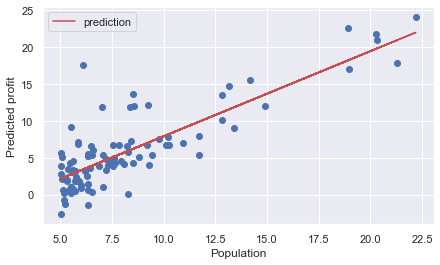

In [25]:
plot_predicted_profit(X, Y, 1.155, -3.635)

Other values of $a$ and $b$ cannot not explain the relationship between `population` and `profit`.

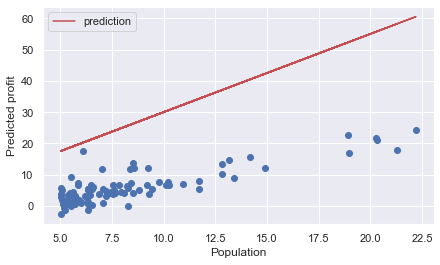

In [26]:
plot_predicted_profit(X, Y, 2.5, 5.0)

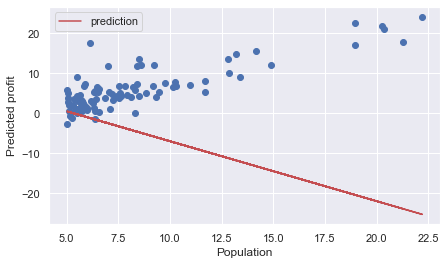

In [27]:
plot_predicted_profit(X, Y, -1.5, 8.0)

Error value (or the loss) provide another glimpse to model performance.

In [28]:
def compute_loss(X, Y, a, b):
    """
    Computes the mean loss / distance between real and predicted values
    Args: Population (NumPy), Profit (NumPy), intercept, slope
    Returns the loss / mean distance between real and predicted profit.
    """
    Y_pred = a * X + b
    distances = (Y - Y_pred) ** 2
    return distances.mean()

Mean loss with slope and intercept as found earlier returned 8.977.

In [29]:
compute_loss(X, Y, 1.155, -3.635)

8.977839860618692

Other values for slope and intercept returned much higher loss.

In [30]:
compute_loss(X, Y, 3, 2)

483.3689144739422

The mean loss could be plotted along with the other data.

In [31]:
def plot_predicted_profit(X, Y, a, b):
    """
    Plots real profit against predicted profit
    Args: Population (NumPy), Profit (NumPy), intercept, slope
    Returns a scatter plot with real data, a correlation line of predicted values, and the mean loss
    """
    Y_pred = a * X + b
    
    plt.figure(figsize = (7, 4))
    plt.scatter(X, Y)
    plt.plot(X, Y_pred, c = "r", label = f"loss:{compute_loss(X, Y, a, b)}")
    plt.xlabel("Population")
    plt.ylabel("Predicted profit")
    plt.legend()
    plt.show()

The plots below show Loss values with different slopes and intercepts.

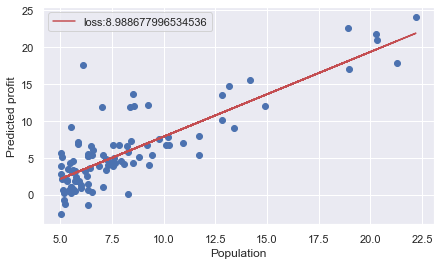

In [32]:
plot_predicted_profit(X, Y, 1.15, -3.63)

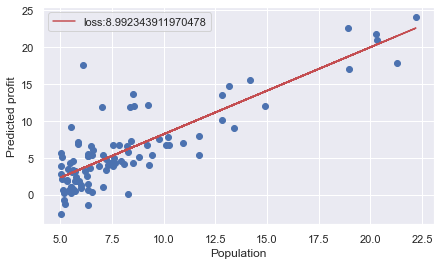

In [33]:
plot_predicted_profit(X, Y, 1.18, -3.6)

In addition to $MSE$, $RMSE$, and $R^2$, the data alow for computing loss with gradient descent.

In [34]:
def perform_step(X: float, 
                 Y: float, 
                 a: float, 
                 b: float, 
                 learining_rate: float):
    """
    Performs steps to compute gradients
    Args:
        X: Features (NumPy array)
        Y: Target (NumPy array)
        a: Intercept
        b: Slope
        learning_rate: step to perform gradient descent
    Returns adjusted Intercept (a) and Slope (b)
    """
    a_gradient = -2 / len(X) * np.sum(X * (Y - (a * X + b)))
    b_gradient = -2 / len(Y) * np.sum(Y - (a * X + b ))
    
    a_new = a - learining_rate * a_gradient
    b_new = b - learining_rate * b_gradient
    
    return (a_new, b_new)

#### 6. Compute Loss 

Loss is computed with different values of $a$ and $b$ for 100 steps with learning rate of 0.01 by applying gradient descent.

In [35]:
a_start, b_start = 5, 3
learning_rate = 0.01

for step in range(100):
    a_start, b_start = perform_step(X, Y, a_start, b_start, learning_rate)
print(f"Updated slope: {a_start}, Updated intercept: {b_start}.")

Updated slope: 0.7416098879733609, Updated intercept: 0.5977483971467694.


The loss is too high with $a = 5$ and $b = 3$.

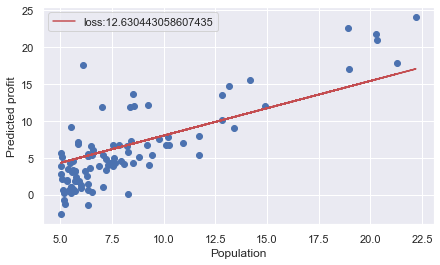

In [36]:
plot_predicted_profit(X, Y, a_start, b_start)

In [37]:
a_start, b_start = 2, 1
learning_rate = 0.01

for step in range(100):
    a_start, b_start = perform_step(X, Y, a_start, b_start, learning_rate)
print(f"Updated slope: {a_start}, Updated intercept: {b_start}.")

Updated slope: 0.8593371174876834, Updated intercept: -0.574123364267239.


It is slightly lower for $a = 2$ and $b = 1$.

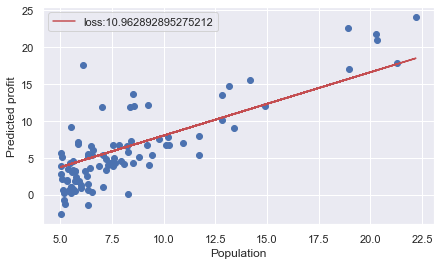

In [38]:
plot_predicted_profit(X, Y, a_start, b_start)

In [39]:
a_start, b_start =  1.155, -3.365
learning_rate = 0.01

for step in range(100):
    a_start, b_start = perform_step(X, Y, a_start, b_start, learning_rate)
print(f"Updated slope: {a_start}, Updated intercept: {b_start}.")

Updated slope: 1.155981637588146, Updated intercept: -3.526960509234201.


The found values of $a$ and $b$ return the lowest loss so far.

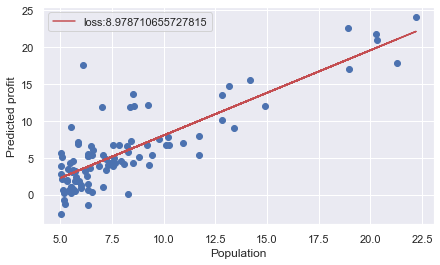

In [40]:
plot_predicted_profit(X, Y, a_start, b_start)

In [41]:
a_start, b_start = 1.155, -3.635
learning_rate = 0.001

for step in range(100):
    a_start, b_start = perform_step(X, Y, a_start, b_start, learning_rate)
print(f"Updated slope: {a_start}, Updated intercept: {b_start}.")

Updated slope: 1.1676491498608783, Updated intercept: -3.64310040680309.


The last try returns the lowest loss, which is almost identical to the one computer earlier (8.977).

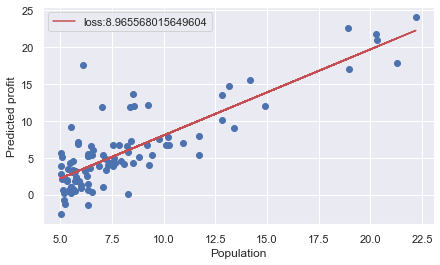

In [42]:
plot_predicted_profit(X, Y, a_start, b_start)

To summarize, the Intercept and the Slope of regression line for Population and Profit data are -3.635 and 1.155, respectively. The Loss fell to 8.974 after 100 iterations with learing rate = 0.01 with starting points -3.8 for $a$ and 1.143 - for $b$.

----------

## II. Logistic Regression

Logistic Regression is a classification algorithm used to predict discrete values (while regression tasks are applicable to predicting continuous values). Each output is capped to 0 or 1, regardless its value.

At the very heart of Logistic Regression is the so-called *Sigmoid* function. It is an S-shape class of functions when plotted. The most prominent Sigmoid function is the so-called *Logistic function* which in mathematical terms is expressed with the following formula: $f(x) = \frac{1}{1 + e^{-x}}$. It takes any $x$ value and maps it to a $y$ value which ranges from 0 to 1. Plotting the function for a range of $x$ values proofs this claim and results in the aforementioned S-shape curve.

In [43]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

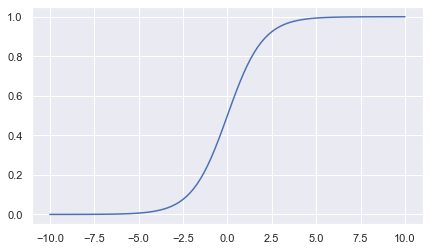

In [44]:
plt.figure(figsize = (7, 4))
x = np.linspace(-10, 10, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

For Linear Regression, the hypothesis was defined as $ \tilde{y} = a X + b$ , whose output range was the set of all real numbers. For Logistic Regression, the hypothesis is $ \tilde{y} = sigmoid(a X + b)$, whose output range is between 0 and 1 because after applying a sigmoid function, the output is always a number between 0 and 1. Thus, $\tilde{y} = \frac{1}{1 + e^{-(a X + b)}}$.

A loss function is minimized to find the global minimum, i.e., to determine the optimal parameters(*a* and *b*) which help for making the best predictions. A binary classification problem requires determining if an output is 0 or 1. It is computed by applying the *Binary Coss-Entropy Loss function*: $J(a,b) = \frac{1}{m} \sum_{i=1}^m L(\tilde{y}^{(i)}, y_{i}) = - \frac{1}{m} \sum_{i=1}^m [(y^{(i)} log(\tilde{y}^{(i)}) + (1 - y^{(i)} log(1 - \tilde{y}^{(i)})]$,

where $J(a, b)$ is the overall cost/loss of the training set and $L$ is the cost for $i^{th}$ training example.

In addition to hypothesis function and loss function, classification task needs the Gradient Descent Algorithm to find the optimal values of parameters like this: 

$a := a - lr * \partial a$

$b := b - lr * \partial b$

where, $\partial a$ is the partial derivative of the Loss function with respect to $a$, and $\partial b$ is the partial derivative of the Loss function with respect to $b$.

How Logistic Function, the Cross Entropy and Gradient Descent work is demonstrated with a small dataset below. It has 100 samples and 3 columns. They store information about students grades and their admission status. The dataset is taken from [here](https://github.com/kumudlakara/Medium-codes/blob/main/logistic_regression/student_result_data.txt).

#### 1. Load Data

In [45]:
student_data = pd.read_csv("data/student_admission.txt", header = None)

In [46]:
student_data.columns = ["grade1", "grade2", "admission"]
student_data

,grade1,grade2,admission
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


In [47]:
student_data.shape

(100, 3)

All figures are numeric and there are not missing values.

In [48]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   grade1     100 non-null    float64
 1   grade2     100 non-null    float64
 2   admission  100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


#### 2. Exploratory Data Analysis. Visualizations

The plot below shows the relationship between Grade 1 and Grade 2. Dots are colored according to their admission status. It is visible that students who had higher Grades 1 and Grades 2 were more likely to be admitted.

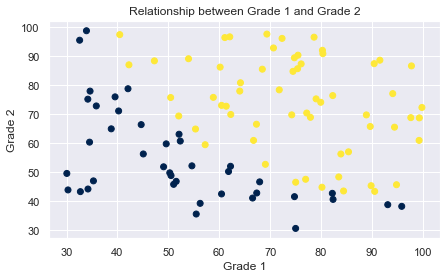

In [49]:
plt.figure(figsize = (7, 4))
plt.scatter(student_data["grade1"], student_data["grade2"], c = student_data["admission"], cmap = "cividis")
plt.xlabel("Grade 1")
plt.ylabel("Grade 2")
plt.title("Relationship between Grade 1 and Grade 2")
plt.show()

The second plot shows how Grade 1 relates to admission status.

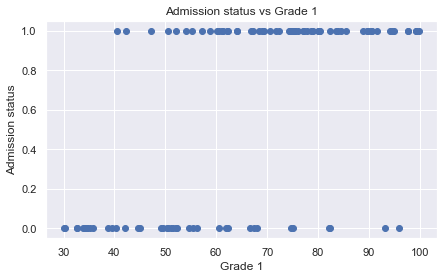

In [50]:
plt.figure(figsize = (7, 4))
plt.scatter(student_data.grade1, student_data.admission)
plt.xlabel("Grade 1")
plt.ylabel("Admission status")
plt.title("Admission status vs Grade 1")
plt.show()

There is close to uniform distribution of both type of grades.

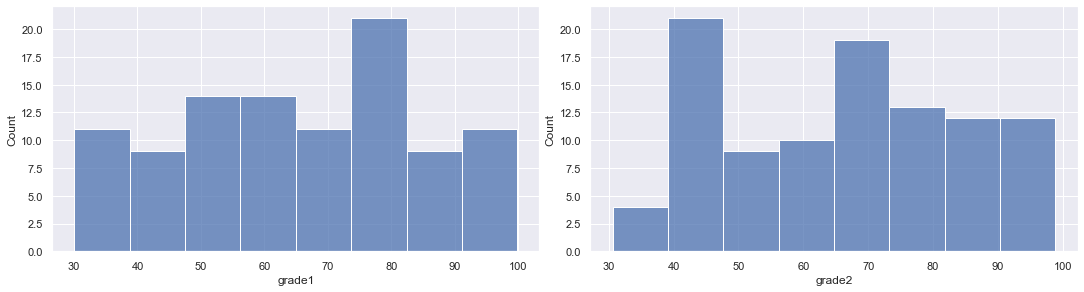

In [51]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 4))
idx = 0
axs = axs.flatten()
for k, v in student_data[["grade1", "grade2"]].items():
    sns.histplot(x = k, data = student_data, ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

The plot below shows that there are 50% more admitted students (1) than those who didn't achive sufficiently high grades.

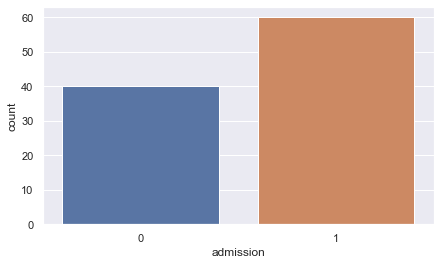

In [52]:
plt.figure(figsize = (7, 4))
sns.countplot(x = "admission", data = student_data) 
plt.show()

#### 3. Preprocess and prepare functions

Labels (admission status) were separated from the other features. They were stored in $y$, whereas the remaining data - in $X$.

In [53]:
X = student_data.drop(["admission"], axis = 1)
y = student_data["admission"]
X.shape, y.shape

((100, 2), (100,))

Label values were converted into a *NumPy* array since `resize()` does not work with *Pandas* data types (see below).

In [54]:
y = y.to_numpy()

The functions below wrap up all opertions for Logistic and Loss computations, and for calculating gradient descent. Constant values were stored in variables.

In [55]:
NUM_ROWS = X.shape[0]
NUM_COLS = X.shape[1]
BATCH_SIZE = 10
EPOCHS = 1000
LR = 0.01

In [56]:
def sigmoid(z):
    """
    Computes output of sigmoid function.
    Args: Hypothesis in the form 'aX+b'
    Returns a number between 0 and 1 - an output of sigmoid function
    """
    return 1.0/(1 + np.exp(-z))

In [57]:
def compute_loss(y, y_pred):
    """
    Computes loss value.
    Args: 
        y: Observed values
        y_pred: Predicted values
    Returns loss value
    """
    loss = -np.mean(y * (np.log(y_pred)) - (1 - y) * np.log(1 - y_pred))
    
    return loss

In [58]:
def compute_gradients(X, y, y_pred):
    """
    Computes the gradients with respect to a and b
    Args:
        X: Features (independent variables)
        y: Observed values (y true)
        y_pred: Predicted values
    """
    da = (1 / NUM_ROWS) * np.dot(X.T, (y_pred - y))
    db = (1 / NUM_ROWS) * np.sum((y_pred - y)) 
    return da, db

In [59]:
def normalize_features(X):
    """
    Normalize feature values with standard score
    Args: X: Features
    Returns Normalized features with mean 0 and std 1.
    """
    for i in range(NUM_COLS):
        X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    return X

In [60]:
def train(X, y, batch_size, epochs, lr):
    """
    Peforms train computations by gradient descent 
        so as the Loss and Sigmoid function find the 
        arguments (a and b) which minimize the Loss function.
    Args:
        X: Features (Pandas DataFrame or a NumPy array)
        y: Labels (NumPy array)
        batch_size: Number of samples used to compute a step of a gradient descent (int)
        epochs: Number of times all samples are used for calculating gradient descent (int)
        lr: Learning rate, float value used to compute partial derivative for gradient descent (float)
    Returns:
        a: Weights of X, which minimize the Loss function (list)
        b: Bisa term, which minimizes the Loss function (float)
        losses: Loss values for each epoch (list)
    """
    # Initialize weights and bias to zeros.
    a = np.zeros((NUM_COLS, 1))
    b = 0
    
    # Reshape y
    y = y.reshape(NUM_ROWS, 1)
    
    # Normalize inputs
    X = normalize_features(X)
    
    # Create empty list to store losses
    losses = []
    
    # Training loop
    for epoch in range(epochs):
        for i in range((NUM_ROWS - 1) // batch_size + 1):
            
            # Define batches, SGD
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = X[start_i:end_i]
            yb = y[start_i:end_i]
            
            # Calculate hypothesis/prediction
            y_pred = sigmoid(np.dot(xb, a) + b)
            
            # Get the gradients of loss w.r.t parameters
            da, db = compute_gradients(xb, yb, y_pred)
            
            # Update the parameters
            a -= lr * da
            b -= lr * db
        
        # Calculate loss and append it to the list
        l = compute_loss(y, sigmoid(np.dot(X, a) + b))
        losses.append(l)
        
    return a, b, losses

#### 4. Train model and evaluate performace

Data were passed to the train function, along with arguments of the modelling hyperparameters.

In [61]:
a, b, l = train(X, y, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR)

The weights and bias which minimize the loss function, as well as a list of the error values of the loss functions for all epochs are printed below.

In [62]:
print(f"Weights of X which minimize loss:\n{a}.")
print("============================")
print(f"Bias term which minimize loss: {b}")
print("============================")
print(f"Losses at each epoch (iteration): {list(l)}")

Weights of X which minimize loss:
[[1.28560598]
 [1.15283148]].
Bias term which minimize loss: 0.46653588827302456
Losses at each epoch (iteration): [0.13813063211302076, 0.1376345752176592, 0.1371412511865667, 0.13665064579941502, 0.13616274485598054, 0.13567753417721903, 0.1351949996063224, 0.13471512700975585, 0.13423790227827673, 0.1337633113279342, 0.1332913401010505, 0.13282197456718317, 0.132355200724069, 0.13189100459854974, 0.13142937224747883, 0.1309702897586102, 0.13051374325146897, 0.13005971887820375, 0.1296082028244213, 0.12915918131000306, 0.12871264058990411, 0.12826856695493458, 0.12782694673252296, 0.1273877662874631, 0.12695101202264303, 0.12651667037975714, 0.1260847278400013, 0.12565517092475098, 0.12522798619622313, 0.12480316025812119, 0.12438067975626364, 0.12396053137919655, 0.12354270185879007, 0.12312717797081887, 0.12271394653552686, 0.12230299441817621, 0.12189430852958127, 0.1214878758266267, 0.12108368331277117, 0.12068171803853538, 0.12028196710197588, 0

The minimum and maximum loss values achived during training are show below, as well as the learning curve.

In [63]:
min(l), max(l)

(0.030448998997276024, 0.13813063211302076)

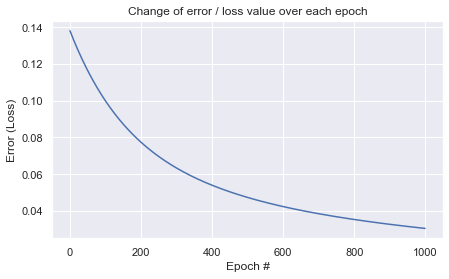

In [64]:
plt.figure(figsize = (7, 4))
plt.plot(l)
plt.xlabel("Epoch #")
plt.ylabel("Error (Loss)")
plt.title("Change of error / loss value over each epoch")
plt.show()

In [65]:
def predict(X):
    """
    Predict label (class) of a given sample.
    Args: Features (Pandas DataFrame or NumPy array)
    Returns predicted labels (classes)
    """
    X = normalize_features(X)
    
    # Calculate presictions/y_pred
    preds = sigmoid(np.dot(X, a) + b)
    
    # Create empty List to store predictions
    pred_class = []    
    
    # Define conditions to determine class
    pred_class = [1 if i > 0.5 else 0 for i in preds]
    
    return np.array(pred_class)

Predicted labels of $X$ - the data the model was trained on, are displayed below.

In [66]:
predict(X)

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

One of the most widely used evaluation metrics for classification tasks is "accuracy". It shows the ratio of correctly predcted against all samples. The higher accuracy score, the better the model.

In [67]:
def accuracy(y, y_pred):
    """
    Compute accuracy, i.e. samples with correctly predicted class.
    Args:
        y: Observed values (true values)
        y_pred: Predicted values
    """
    accuracy = np.sum(y == y_pred) / len(y)
    return accuracy

An "accuracy" of 90% is a rather good performance. To check if all functions work properly, this result was compared with the output of a very simple `scikit-learn` Logistic Regression.

In [68]:
print(f"Accuracy score: {accuracy(y, y_pred = predict(X)):.2f}%.")

Accuracy score: 0.90%.


#### 5. Compare manual Logictic Regression with Logistic Regression in `scikit-learn`

In [69]:
lg = LogisticRegression()
lg.fit(X, y)
print(f"Accuracy score: {accuracy_score(y, lg.predict(X)):.2f}%.")

Accuracy score: 0.89%.


Accuracy obtained by `scikit-learn` Logistic Regression model reached almost 90% as the manually compiled one.

In summary, this example showed how Logistic Regression works. It relies on `sigmoid` and loss (`categorical crossentropy`) functions, and computes the weights with gradient descent. 

----------

## III. Clustering

Clustering is an unsupervised machine learning type of tasks to divide the entire data into groups (clusters) based on the paterns in the data. In contrast to supervised learning, here we do not have target (or labels) $y$ to predict as in supervised learning (e.g., in regression and classification). To form a cluster, all the data points should be similar to each other. Furthermore, the data points from different clusters should be as different as possible. Distance of points within and between clusters is computed with *inertia*. It tells how far the points within a cluster are. So, inertia actually calculates the sum of distances of all points within a cluster from the centroid of that cluster.

Inertia is calculated for all clusters and the final inertial value is the sum of all these distances. This distance within the clusters is known as *intracluster distance* and it show be as low as possible. On the other hand, the different clusters should be as distant from each other as possible. Here comes the *Dunn index*, which measures the distance between two clusters. This distance between the centroids of two different clusters is known as inter-cluster distance. The Dunn index is comuted with the following formula: $Dunn \space Index = \frac{min(inter-cluster distance}{max(intra-cluster distance)}$. In other words, Dunn index is the ratio of the minimum of inter-cluster distances and maximum of intracluster distances.

To illustrate how clustering works, the code lines below implement *K-means* technique - an algorithm that tries to minimize the sum of distances between the points and their respective cluster centroid. This example uses "Gender Income Spending" dataset taken from Kaggle ([link](https://www.kaggle.com/datasets/harrimansaragih/clustering-data-id-gender-income-spending)). It has 1113 samples with 5 features: *ID*, *Gender_Code*, *Region*, *Income*, and *Spending*. There is not a target / label variable. 

#### 1. Load Data

In [70]:
spending_data = pd.read_csv("data/ClusteringHSS.csv")

In [71]:
spending_data.head()

,ID,Gender_Code,Region,Income,Spending
0,1,Female,Rural,20.0,15.0
1,2,Male,Rural,5.0,12.0
2,3,Female,Urban,28.0,18.0
3,4,Male,Urban,40.0,10.0
4,5,Male,Urban,42.0,9.0


In [72]:
spending_data.shape

(1113, 5)

#### 2. Exploratory Data Analysis. Visualizations

Data about males slightly outnumer females.

In [73]:
spending_data.Gender_Code.value_counts()

Male      572
Female    535
Name: Gender_Code, dtype: int64

Slightly more people in the dataset come from Rural areas. The others live in Urban territories.

In [74]:
spending_data.Region.value_counts()

Rural    558
Urban    549
Name: Region, dtype: int64

Values in Gender and Region are encoded thus to replace string values with numeric ones.

In [75]:
spending_data["Gender_Code"] = spending_data["Gender_Code"].replace({"Male": 0, "Female": 1})
spending_data["Region"] = spending_data["Region"].replace({"Rural": 0, "Urban": 1})
spending_data

,ID,Gender_Code,Region,Income,Spending
0,1,1.0,0.0,20.0,15.0
1,2,0.0,0.0,5.0,12.0
2,3,1.0,1.0,28.0,18.0
3,4,0.0,1.0,40.0,10.0
4,5,0.0,1.0,42.0,9.0
...,...,...,...,...,...
1108,1109,1.0,1.0,33.0,16.0
1109,1110,0.0,1.0,48.0,7.0
1110,1111,0.0,1.0,31.0,16.0
1111,1112,0.0,1.0,50.0,14.0


All cells hold numeric data but there are some null values. These were removed.

In [76]:
spending_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1113 non-null   int64  
 1   Gender_Code  1107 non-null   float64
 2   Region       1107 non-null   float64
 3   Income       1107 non-null   float64
 4   Spending     1108 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 43.6 KB


In [77]:
spending_data.dropna(inplace = True)

ID column is set as index.

In [78]:
spending_data.set_index("ID", inplace = True)

The scatter plot below shows the relationship between *Income* and *Spending* for males and females. There is not a common pattern neither in terms of gender, nor in terms of income or spending. At least these features does not suggest so. The correlation table proves this. However, it hints that there might be a relationship between *Income* and *Region*. The latter are plotted thereafter.

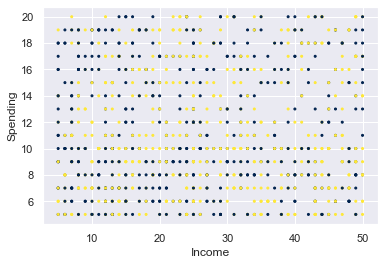

In [79]:
plt.figure(figsize = (6, 4))
plt.scatter(spending_data.Income, spending_data.Spending, c = spending_data.Gender_Code, cmap = "cividis_r", s = 4)
plt.xlabel("Income")
plt.ylabel("Spending")
plt.show()

In [80]:
spending_data.corr()

,Gender_Code,Region,Income,Spending
Gender_Code,1.000000,-0.051925,-0.075007,0.055749
Region,-0.051925,1.000000,0.854943,0.030714
Income,-0.075007,0.854943,1.000000,0.033521
Spending,0.055749,0.030714,0.033521,1.000000


People with higher income (as expected) live in urban areas, whereas those who live in the countryside earn less.

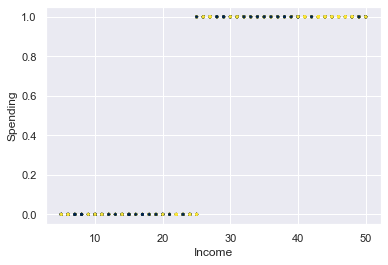

In [81]:
plt.figure(figsize = (6, 4))
plt.scatter(spending_data.Income, spending_data.Region, c = spending_data.Gender_Code, cmap = "cividis_r", s = 4)
plt.xlabel("Income")
plt.ylabel("Spending")
plt.show()

#### 3. Cluster data

The first step in clustering is to choose the number of clusters. In this case, the number of clusters would be 3.

Thereafter, a centroid is randomly selectd for each cluster (these are printed below). All points and the three randomly selected centroids are shown on the plot.

      Gender_Code  Region  Income  Spending
ID                                         
847           0.0     0.0    16.0       8.0
1032          0.0     0.0     5.0       5.0
603           0.0     0.0    13.0       5.0


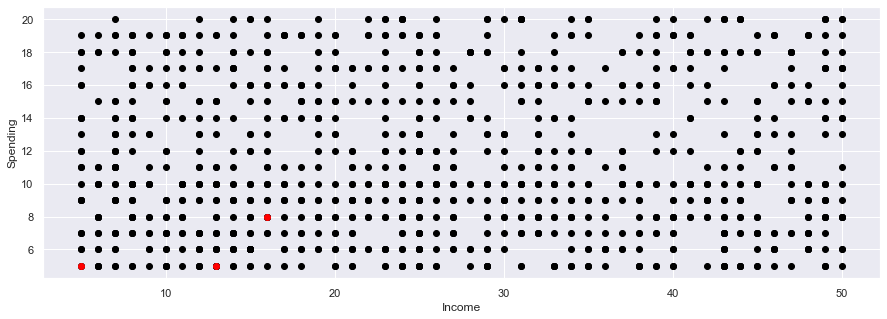

In [82]:
K = 3

Centroids = (spending_data.sample(n = K))

print(Centroids)

plt.scatter(spending_data["Income"], spending_data["Spending"], c = "black")
plt.scatter(Centroids["Income"], Centroids["Spending"], c = "red")
plt.xlabel("Income")
plt.ylabel("Spending")
plt.show()

The next step requires to assign each point to the closest cluster centroid. Thereafter, once all of the points are assigned to either cluster, the centroids of the newly formed clusters is computed. The algorithm stops when the centroids of newly formed clusters are not changing even after multiple iterations.

In [83]:
diff = 1
j = 0

The code lines below compute intra- and inter-cluster distance between points in *Income* and *Spending*. When they stop changing the cluster they are assigned to, the loop stops.

In [84]:
# Define condition, i.e. no further changes
while diff != 0:
    XD = spending_data
    i = 1
    for index1, row_c in Centroids.iterrows():
        ED = []
        for index2, row_d in XD.iterrows():
            d1 = (row_c["Income"] - row_d["Income"]) ** 2
            d2 = (row_c["Spending"] - row_d["Spending"]) ** 2
            d = np.sqrt(d1 + d2)
            ED.append(d)
        spending_data[i] = ED
        i = i + 1
    
    C = []
    for index, row in spending_data.iterrows():
        min_dist = row[1]
        pos = 1
        for i in range(K):
            if row[i + 1] < min_dist:
                min_dist = row[i + 1]
                pos = i + 1
        C.append(pos)
    
    spending_data["Cluster"] = C
    Centroids_new = spending_data.groupby(["Cluster"]).mean()[["Spending", "Income"]]
    if j == 0:
        diff = 1
        j = j + 1
    else:
        diff = (Centroids_new["Spending"] - Centroids["Spending"]).sum() + (Centroids_new["Income"] - Centroids["Income"]).sum()
        print(f"Sum of minimum distance: {diff.sum()}")
    Centroids = spending_data.groupby(["Cluster"]).mean()[["Spending", "Income"]]

Sum of minimum distance: 15.148120174416931
Sum of minimum distance: 6.625550854112911
Sum of minimum distance: 4.311903524121538
Sum of minimum distance: 3.113053299451904
Sum of minimum distance: 2.7779064622542204
Sum of minimum distance: 2.5451989523974934
Sum of minimum distance: 1.728183785022459
Sum of minimum distance: 0.7170752459280649
Sum of minimum distance: 1.107957083212236
Sum of minimum distance: 0.0


The plot blow shows the new centroids and the points grouped in different clusters after computing intra- and inter-cluster distance.

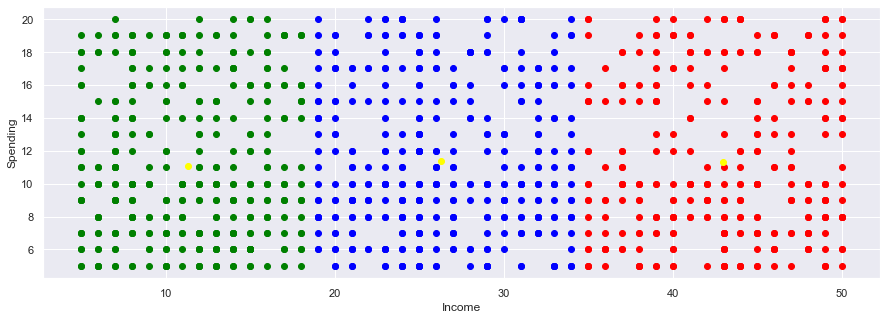

In [85]:
color = ["red", "green", "blue"]

for k in range(K):
    data = spending_data[spending_data["Cluster"] == k + 1]
    plt.scatter(data["Income"], data["Spending"], c = color[k])
    
plt.scatter(Centroids["Income"], Centroids["Spending"], c = "yellow")
plt.xlabel("Income")
plt.ylabel("Spending")
plt.show()

#### 4. Compare manual k-mean clustering with KMeans of `scikit-learn`

To check if the above algorithm was properly compiled, its output was compared with the one produced by KMeans of `scikit-learn`. The algorithm was initialized (with three clusters) and data was passed to it. Predicted clusters were stored in variable which was used to color the points according to the group they were assigned to.

In [86]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(spending_data)
predicted_clusters = kmeans.predict(spending_data)

In [87]:
predicted_clusters

array([2, 1, 2, ..., 2, 0, 2])

The plot below demonstrates that the points were put in three clusters separated from one another in the same way.

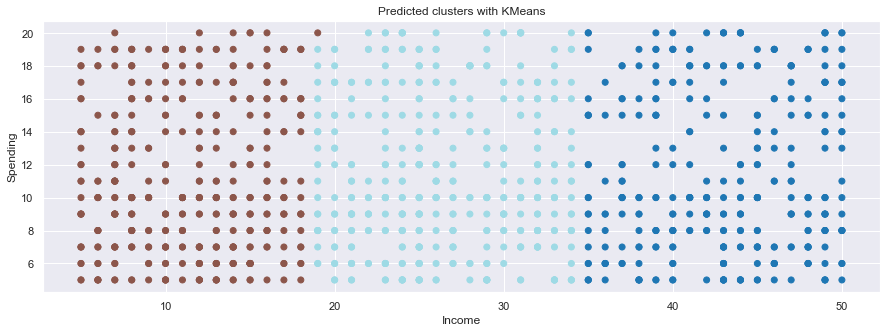

In [88]:
plt.scatter(spending_data.Income, spending_data.Spending, c = predicted_clusters, cmap="tab20")
plt.xlabel("Income")
plt.ylabel("Spending")
plt.title("Predicted clusters with KMeans")
plt.show()